The diffusion tensor model is a model that describes the diffusion within a voxel. First proposed by Basser and colleagues [Basser1994], it has been very influential in demonstrating the utility of diffusion MRI in characterizing the micro-structure of white matter tissue and of the biophysical properties of tissue, inferred from local diffusion properties and it is still very commonly used.

The diffusion tensor models the diffusion signal for a single direction as:

$$ S(g) = S_0 e^{-\gamma^2 g^2 D \delta^2 (\Delta - \frac{\delta}{3})} $$

Where:
- $S(g)$ is the signal intensity with gradient,
- $S_0$ is the signal intensity without gradient,
- $\gamma$ is the gyromagnetic ratio,
- $g$ is the gradient strength,
- $D$ is the diffusion coefficient,
- $\delta$ is the duration of the gradient pulse,
- $\Delta$ is the time between the gradients.

Now the above equation when generalized to every gradient direction, the formula is :

$$ \frac{S(\mathbf{g}, b)}{S_0} = e^{-b\mathbf{g}^\text{T}D\mathbf{g}} $$

Where $\mathbf{g}$ is a unit vector in 3 space indicating the direction of measurement and b are the parameters of measurement, such as the strength and duration of diffusion-weighting gradient. $S(\mathbf{g}, b)$ is the diffusion-weighted signal measured and $S_0$ is the signal conducted in a measurement with no diffusion weighting. $D$ is a positive-definite quadratic form, which contains six free parameters to be fit.

$$ D = \begin{bmatrix}
D_{xx} & D_{xy} & D_{xz} \\
D_{yx} & D_{yy} & D_{yz} \\
D_{zx} & D_{zy} & D_{zz} \\
\end{bmatrix} $$

This matrix is a variance/covariance matrix of the diffusivity along the three spatial dimensions. Note that we can assume that diffusivity has antipodal symmetry, so elements across the diagonal are equal. For example: $D_{xy} = D_{yx}$. This is why there are only 6 free parameters to estimate here.

In the following example we show how to reconstruct your diffusion datasets using a single tensor model.


### Import the necessary libraries

In [ ]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [1]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table

In [2]:
import dipy.reconst.dti as dti


/Users/atharva/miniforge3/envs/dipy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download a sample dataset. (You can also use your own data)

In [3]:
from dipy.data import get_fnames


In [4]:
hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')


/var/folders/d_/ndgr38dd1kq0zjyd0pcqc62c0000gn/T/ipykernel_2196/1769394083.py:1: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')


Now we will load the nifti file that we just downloaded and get the bvalues an bvectors and create a gradient table out of it

In [5]:
data, affine = load_nifti(hardi_fname)

bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

print('data.shape (%d, %d, %d, %d)' % data.shape)


data.shape (81, 106, 76, 160)


/var/folders/d_/ndgr38dd1kq0zjyd0pcqc62c0000gn/T/ipykernel_2196/3476192877.py:4: UserWarning: Pass ['bvecs'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  gtab = gradient_table(bvals, bvecs)


Notice the shape of the data that we talked about earlier. It is a 4D dataset with voxel indices and the voxel data that is stanford's HARDI scheme dataset

In [6]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=4,
                             numpass=4, autocrop=False, dilate=1)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)


maskdata.shape (81, 106, 76, 160)


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(maskdata[:, :, maskdata.shape[2] // 2, 0].T, cmap='gray', origin='lower')

NameError: name 'plt' is not defined

You can see that the mask has reduced the data size as it creates a mask. You can play with the parameters for your own dataset for more accurate segmentation masks over the image. 

### DTI fitting 

Now that we have prepared the datasets we can go forward with the voxel reconstruction. First, we instantiate the Tensor model in the following way.

In [ ]:
tenmodel = dti.TensorModel(gtab)


Fitting the data is very simple. We just need to call the fit method of the TensorModel in the following way:

In [ ]:
tenfit = tenmodel.fit(maskdata)


The fit method creates a TensorFit object which contains the fitting parameters and other attributes of the model. You can recover the 6 values of the triangular matrix representing the tensor D. By default, in DIPY, values are ordered as (Dxx, Dxy, Dyy, Dxz, Dyz, Dzz). The tensor_vals variable defined below is a 4D data with last dimension of size 6.

In [ ]:
tensor_vals = dti.lower_triangular(tenfit.quadratic_form)


You can also recover other metrics from the model. For example we can generate fractional anisotropy (FA) from the eigen-values of the tensor. FA is used to characterize the degree to which the distribution of diffusion in a voxel is directional. That is, whether there is relatively unrestricted diffusion in one particular direction.

Mathematically, FA is defined as the normalized variance of the eigen-values of the tensor:

$$ FA = \sqrt{\frac{3}{2}} \cdot \sqrt{\frac{(\lambda_1 - \lambda_{mean})^2 + (\lambda_2 - \lambda_{mean})^2 + (\lambda_3 - \lambda_{mean})^2}{\lambda_1^2 + \lambda_2^2 + \lambda_3^2}} $$

Where:
- $\lambda_1, \lambda_2, \lambda_3$ are the eigenvalues of the diffusion tensor,
- $\lambda_{mean} = \frac{\lambda_1 + \lambda_2 + \lambda_3}{3}$ is the mean of the eigenvalues.
 
 
Note that FA should be interpreted carefully. It may be an indication of the density of packing of fibers in a voxel, and the amount of myelin wrapping these axons, but it is not always a measure of “tissue integrity”. For example, FA may decrease in locations in which there is fanning of white matter fibers, or where more than one population of white matter fibers crosses.

In [ ]:
print('Computing anisotropy measures (FA, MD, RGB)')
from dipy.reconst.dti import fractional_anisotropy, color_fa

FA = fractional_anisotropy(tenfit.evals)

Computing anisotropy measures (FA, MD, RGB)


In the background of the image the fitting will not be accurate there is no signal and possibly we will find FA values with nans (not a number). We can easily remove these in the following way.

In [ ]:
FA[np.isnan(FA)] = 0


In [ ]:
print("The shape of FA map is: ", FA.shape)

The shape of FA map is:  (81, 106, 76)


Notice that the FA shape printed is for each voxel and hence it is going from a DWI to an interpretable metric.

Now let us visualize how the FA looks with a simple matplotlib import and visualizing one slice. You can also save the FA map in nifti format easily with the command below and visualize the entire volume in dipy horizon very easily.

save_nifti('tensor_fa.nii.gz', FA.astype(np.float32), affine)


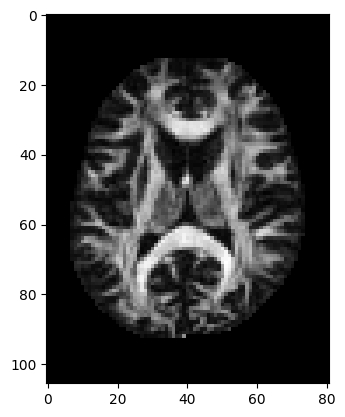

In [ ]:

plt.imshow(np.rot90(FA[:,:,37]),cmap = "gray")

Now lets calulate the other metric with the dti.mean_diffusivity on the eigen values obtained with the fitted model. 

In [ ]:
MD1 = dti.mean_diffusivity(tenfit.evals)


This is simply the mean of the eigenvalues of the tensor. Since FA is a normalized measure of variance and MD is the mean, they are often used as complimentary measures. In DIPY, there are two equivalent ways to calculate the mean diffusivity. One is by calling the mean_diffusivity module function on the eigen-values of the TensorFit class instance that is `tenfit.md`. 

Lets visualize the same slice with MD map.

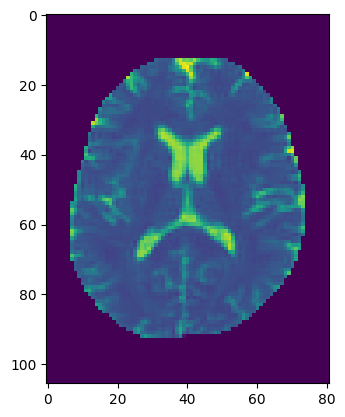

In [ ]:
plt.imshow(np.rot90(MD1[:,:,37]))

In [ ]:
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)


We can also compute the colored FA or RGB-map `[Pajevic1999]`. First, we make sure that the FA is scaled between 0 and 1. RGB corresponds to XYZ directions.

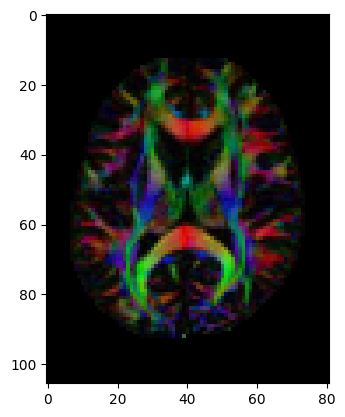

In [ ]:
plt.imshow(np.rot90(RGB[:,:,37]))

If you want to explore in depth, eigen directions and eigen values are also outputted by a simple .evecs and .evals with the dti model fit instance as below. You can uncomment the code and try to see it for your exploration.

In [ ]:
#tenfit.evecs
#tenfit.evals

You can also visualize the tensor ellipsoids in a slice of corpus callosum easily with horizon by a simple chunk of code. Try to uncomment out the code and visualize it.

In [ ]:

# from dipy.data import get_sphere
# sphere = get_sphere('repulsion724')

# from dipy.viz import window, actor

# # Enables/disables interactive visualization
# interactive = False

# scene = window.Scene()

# evals = tenfit.evals[13:43, 44:74, 28:29]
# evecs = tenfit.evecs[13:43, 44:74, 28:29]

# cfa = RGB[13:43, 44:74, 28:29]
# cfa /= cfa.max()

# scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,
#                               scale=0.3))

# print('Saving illustration as tensor_ellipsoids.png')
# window.record(scene, n_frames=1, out_path='tensor_ellipsoids.png',
#               size=(600, 600))
# if interactive:
#     window.show(scene)


# DKI 


The diffusion kurtosis model is an expansion of the diffusion tensor model.In addition to the diffusion tensor (DT), the diffusion kurtosis model quantifies the degree to which water diffusion in biological tissues is non-Gaussian using the kurtosis tensor (KT) [Jensen2005].

Measurements of non-Gaussian diffusion from the diffusion kurtosis model are of interest because they can be used to characterize tissue microstructural heterogeneity [Jensen2010]. Moreover, DKI can be used to: 1) derive concrete biophysical parameters, such as the density of axonal fibers and diffusion tortuosity [Fierem2011] (see Reconstruction of the diffusion signal with the WMTI model); and 2) resolve crossing fibers in tractography and to obtain invariant rotational measures not limited to well-aligned fiber populations [NetoHe2015].

The diffusion kurtosis model expresses the diffusion-weighted signal as:
$$
S(b) = S_0 \exp(-bD + \frac{1}{6} b^2 D^2 K)
$$

where \( S(b) \) is the signal intensity with diffusion weighting, \( S_0 \) is the signal intensity without diffusion weighting, \( b \) is the diffusion weighting factor which is b value, \( D \) is the apparent diffusion coefficient, and \( K \) is the apparent kurtosis coefficient.
K is defined as a matrix like :
\begin{equation}
\mathbf{W} = \begin{pmatrix}
W_{xxxx} & W_{yyyy} & W_{zzzz} & W_{xxyy} & W_{xxzz} & W_{yyzz} \\
W_{xxyy} & W_{xxzz} & W_{yyzz} & W_{xxyz} & W_{xyyz} & W_{xyzz} \\
W_{xxyz} & W_{xyyz} & W_{xyzz} & W_{xzxz} & W_{xzyz} & W_{yzyz} \\
W_{xzxz} & W_{xzyz} & W_{yzyz} & W_{yyyy} & W_{zzzz} & W_{yzzz} \\
W_{xxyy} & W_{xxzz} & W_{xxyz} & W_{yyyy} & W_{yzyz} & W_{yyzz} \\
W_{xxzz} & W_{xxyz} & W_{xyyz} & W_{yzzz} & W_{yzyz} & W_{zzzz}
\end{pmatrix}
\end{equation}

The kurtosis tensor is a fourth-order tensor and can be represented by a 3x3x3x3 matrix due to its symmetries. However, many of these elements are redundant, and only 15 unique elements are needed to fully describe the kurtosis in three-dimensional space. This is often simplified into a compact 1x15 vector for practical computation purposes.

These kurtosis measures can provide insights beyond what is captured by the diffusion tensor in DTI, potentially offering more sensitive biomarkers for the characterization of tissue microstructure in various pathologies.


In [ ]:
import numpy as np
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.segment.mask import median_otsu
from dipy.viz.plotting import compare_maps
from scipy.ndimage import gaussian_filter

### Note that you need a multi-shell data for DKI and hence we download cfin_multib dataset
Here, we use fetch to download a multi-shell dataset which was kindly provided by Hansen and Jespersen (more details about the data are provided in their paper [Hansen2016]). The total size of the downloaded data is 192 MBytes, however you only need to fetch it once.

In [ ]:
fraw, fbval, fbvec, t1_fname = get_fnames('cfin_multib')

data, affine = load_nifti(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

In [ ]:
vals, counts = np.unique(gtab.bvals, return_counts=True)
print(" b values for acquistions are:", vals)

 b values for acquistions are: [   0.  200.  400.  600.  800. 1000. 1200. 1400. 1600. 1800. 2000. 2200.
 2400. 2600. 2800. 3000.]


  
        
#### You might see that the acquisition is done with multiple b values
  
  
  

  Before fitting the data, we perform some data pre-processing. We first compute a brain mask to avoid unnecessary calculations on the background of the image.



In [ ]:
maskdata, mask = median_otsu(data, vol_idx=[0, 1], median_radius=4, numpass=2,
                             autocrop=False, dilate=1)


Since the diffusion kurtosis models involves the estimation of a large number of parameters [TaxCMW2015] and since the non-Gaussian components of the diffusion signal are more sensitive to artefacts [NetoHe2012], it might be favorable to suppress the effects of noise and artefacts before diffusion kurtosis fitting. In this example the effects of noise and artefacts are suppress by using 3D Gaussian smoothing (with a Gaussian kernel with fwhm=1.25) as suggested by pioneer DKI studies (e.g. [Jensen2005], [NetoHe2012]). Although here the Gaussian smoothing is used so that results are comparable to these studies, it is important to note that more advanced noise and artifact suppression algorithms are available in DIPY, e.g. the Marcenko-Pastur PCA denoising algorithm (Denoise images using the Marcenko-Pastur PCA algorithm) and the Gibbs artefact suppression algorithm (Suppress Gibbs oscillations) and the Patch2self method by Fadnavis et.al NeurIPS 2020.

In [ ]:
fwhm = 1.25
gauss_std = fwhm / np.sqrt(8 * np.log(2))  # converting fwhm to Gaussian std
data_smooth = np.zeros(data.shape)
for v in range(data.shape[-1]):
    data_smooth[..., v] = gaussian_filter(data[..., v], sigma=gauss_std)

Now that we have loaded and pre-processed the data we can go forward with DKI fitting. For this, the DKI model is first defined for the data’s GradientTable object by instantiating the DiffusionKurtosisModel object in the following way:

In [ ]:
dkimodel = dki.DiffusionKurtosisModel(gtab)


To fit the data using the defined model object, we call the fit function of this object. For the purpose of this example, we will only fit a single slice of the data:

In [ ]:
data_smooth = data_smooth[:, :, 9:10]
mask = mask[:, :, 9:10]
dkifit = dkimodel.fit(data_smooth, mask=mask)

The fit method creates a DiffusionKurtosisFit object, which contains all the diffusion and kurtosis fitting parameters and other DKI attributes. For instance, since the diffusion kurtosis model estimates the diffusion tensor, all standard diffusion tensor statistics can be computed from the DiffusionKurtosisFit instance. For example, we can extract the fractional anisotropy (FA), the mean diffusivity (MD), the axial diffusivity (AD) and the radial diffusivity (RD) from the DiffusionKurtosisiFit instance. Of course, these measures can also be computed from DIPY’s TensorModel fit, and should be analogous; however, theoretically, the diffusion statistics from the kurtosis model are expected to have better accuracy, since DKI’s diffusion tensor are decoupled from higher order terms effects [Veraar2011], [NetoHe2012]. Below we compare the FA, MD, AD, and RD, computed from both DTI and DKI.

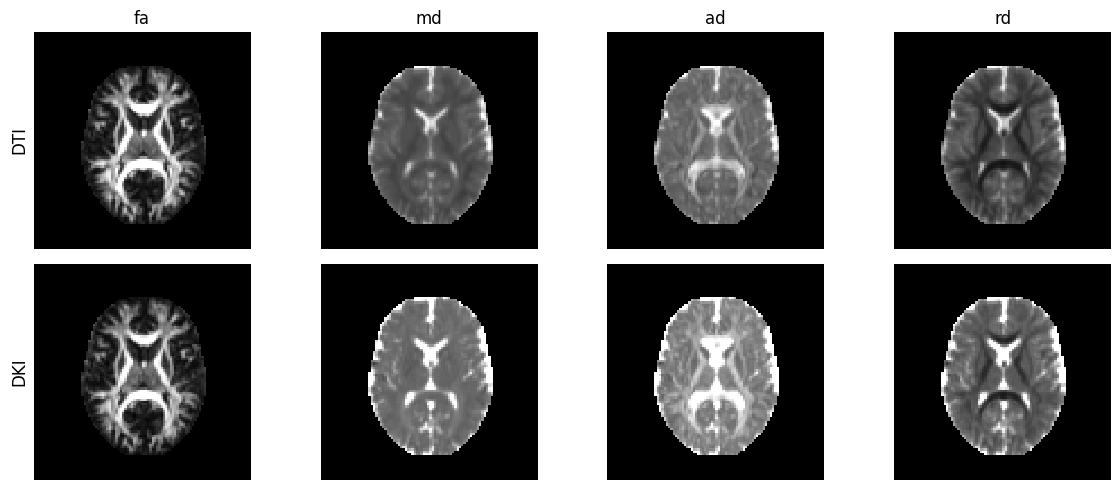

In [ ]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data_smooth, mask=mask)

fits = [tenfit, dkifit]
maps = ['fa', 'md', 'ad', 'rd']
fit_labels = ['DTI', 'DKI']
map_kwargs = [{'vmax': 0.7}, {'vmax': 2e-3}, {'vmax': 2e-3}, {'vmax': 2e-3}]
compare_maps(fits, maps, fit_labels=fit_labels, map_kwargs=map_kwargs,
             filename='Diffusion_tensor_measures_from_DTI_and_DKI.png')


DTI’s diffusion estimates present lower values than DKI’s estimates, showing that DTI’s diffusion measurements are underestimated by higher order effects.

In addition to the standard diffusion statistics, the DiffusionKurtosisFit instance can be used to estimate the non-Gaussian measures of mean kurtosis (MK), the axial kurtosis (AK) and the radial kurtosis (RK).

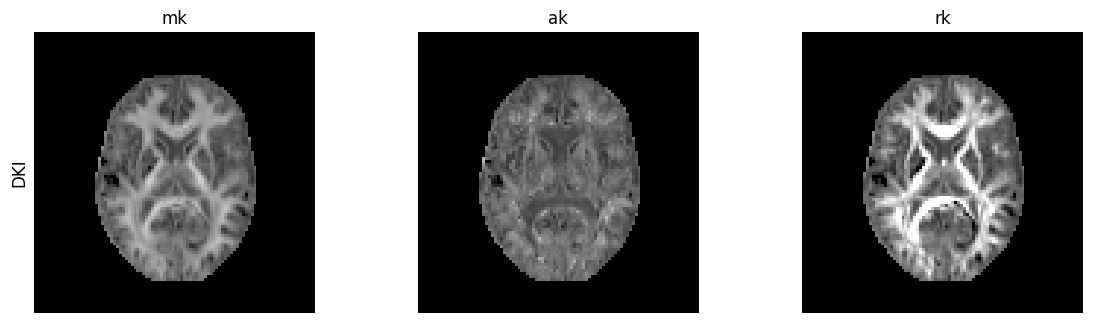

In [ ]:
maps = ['mk', 'ak', 'rk']
compare_maps([dkifit], maps, fit_labels=['DKI'],
             map_kwargs={'vmin': 0, 'vmax': 1.5},
             filename='Kurtosis_tensor_standard_measures.png')